In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

In [2]:
# Membaca file CSV
df = pd.read_csv('data_harga_beras.csv')
# Mengonversi kolom 'Date' menjadi tipe data datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').interpolate(method='linear').reset_index()

# Menampilkan dataframe
df

,Date,C4Super,C4Medium,Bulog
0,2021-01-04,11750.0,10667.000000,9083.0
1,2021-01-05,11750.0,10667.000000,9083.0
2,2021-01-06,11750.0,10667.000000,9083.0
3,2021-01-07,11750.0,10667.000000,9083.0
4,2021-01-08,11750.0,10667.000000,9083.0
...,...,...,...,...
1208,2024-04-26,16167.0,14667.000000,11000.0
1209,2024-04-27,15889.0,14444.666667,11000.0
1210,2024-04-28,15611.0,14222.333333,11000.0
1211,2024-04-29,15333.0,14000.000000,11000.0


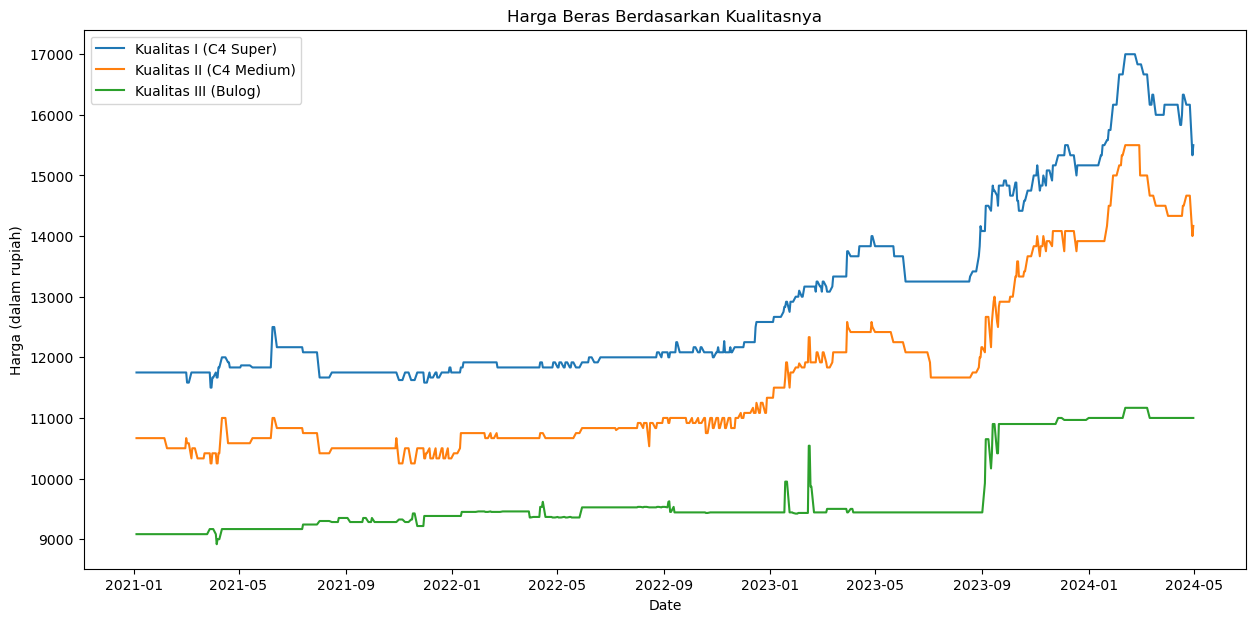

In [3]:
plt.figure(figsize=(15,7))
plt.plot(df['Date'], df['C4Super'], label='Kualitas I (C4 Super)')
plt.plot(df['Date'], df['C4Medium'], label='Kualitas II (C4 Medium)')
plt.plot(df['Date'], df['Bulog'], label='Kualitas III (Bulog)')

# Menambahkan label untuk sumbu x, sumbu y, dan judul grafik
plt.xlabel('Date')
plt.ylabel('Harga (dalam rupiah)')
plt.title('Harga Beras Berdasarkan Kualitasnya')
# Menampilkan legenda
plt.legend()

# Menampilkan grafik
plt.show()

In [4]:
#Menampilkan informasi tentang DataFrame `df`
df.info()

# Menampilkan statistik deskriptif dari DataFrame `df`
df.describe()

# Memeriksa jumlah nilai null (missing values) dalam setiap kolom 
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1213 non-null   datetime64[ns]
 1   C4Super   1213 non-null   float64       
 2   C4Medium  1213 non-null   float64       
 3   Bulog     1213 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 38.0 KB


Date        0
C4Super     0
C4Medium    0
Bulog       0
dtype: int64

In [5]:
# Menetapkan random seed
tf.random.set_seed(123)

In [6]:
# Melakukan drop pada kolom 'C4 Medium' dan 'Bulog'
df = df.drop(['C4Super', 'C4Medium'], axis=1)

In [7]:
# Mengambil nilai dari kolom 'C4Super', mengonversinya menjadi array, dan mengubah tipe data menjadi float32
df = df.filter(['Bulog'])
df = df.values
df = df.astype('float32')

In [8]:
# Normalisasi dataset dengan MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
print(df)


[[0.07377791]
 [0.07377791]
 [0.07377791]
 ...
 [0.9257777 ]
 [0.9257777 ]
 [0.9257777 ]]


In [9]:
# Time series windowing
def prepare_data(df, timesteps):
    X = []
    Y = []
    for i in range(len(df)-timesteps-1):
        X.append(df[i:(i+timesteps)])
        Y.append(df[i + timesteps, 0])  # Hanya kolom 'C4Super' yang menjadi target
    return np.array(X), np.array(Y)

# Menentukan jumlah time steps (hari) yang digunakan untuk memprediksi harga beras berikutnya
timesteps = 1


In [10]:
# Membagi dataset menjadi data latih dan data uji
n_samples = len(df)
train_size = int(n_samples * 0.9)
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

# Persiapkan input dan output
X_train, Y_train = prepare_data(train_data, timesteps)
X_test, Y_test = prepare_data(test_data, timesteps)

In [11]:
# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print('Train Shape = {0}'.format(X_train.shape))
print('Test Shape = {0}'.format(X_test.shape))


Train Shape = (1089, 1, 1)
Test Shape = (120, 1, 1)


In [12]:
# Inisiasi Hyperparameter
num_neuron = 20
num_epoch = 50
num_batch = 16
adam_optimizer = Adam(learning_rate=0.001)

# Membuat model LSTM
model = Sequential()
model.add(LSTM(4, activation='tanh', recurrent_activation='sigmoid', 
               return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(num_neuron, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, bias_initializer='zeros'))

model.summary()

# Build model and compile
model.compile(optimizer=adam_optimizer, loss='mse', metrics=['MAPE'])

# Melatih model dengan menggunakan set data Training
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epoch, batch_size=num_batch, verbose=1)

C:\Users\Windows\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 4)           │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117 (8.27 KB)

 Trainable params: 2,117 (8.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - MAPE: 54312.9062 - loss: 0.1059 - val_MAPE: 77.5111 - val_loss: 0.5355
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MAPE: 185320.8281 - loss: 0.0505 - val_MAPE: 62.7030 - val_loss: 0.3508
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAPE: 194598.0781 - loss: 0.0403 - val_MAPE: 55.4408 - val_loss: 0.2742
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAPE: 173166.9219 - loss: 0.0323 - val_MAPE: 44.0176 - val_loss: 0.1728
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - MAPE: 155738.1719 - loss: 0.0228 - val_MAPE: 27.9322 - val_loss: 0.0696
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - MAPE: 124595.5469 - loss: 0.0113 - val_MAPE: 14.3353 - val_loss: 0.0183
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MAPE: 86071.2500 - loss: 0.0077 - val_MAPE: 3.3417 - val_loss: 0.0010
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MAPE: 112364.6250 - loss: 0.0070 - val_MAPE: 6.2209 - val_loss: 0.0035
Epoch 9/

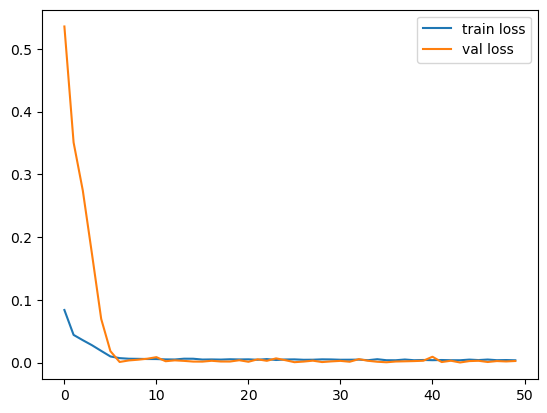

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [14]:
# Predicting
train_predict = model.predict(X_train, verbose=0)
test_predict = model.predict(X_test, verbose=0)

print("Hasil prediksi pada data latih (normalisasi):")
print(train_predict)

print("Hasil prediksi pada data uji (normalisasi):")
print(test_predict)

Hasil prediksi pada data latih (normalisasi):
[[0.09369689]
 [0.09369689]
 [0.09369689]
 ...
 [0.86609447]
 [0.86609447]
 [0.86609447]]
Hasil prediksi pada data uji (normalisasi):
[[0.874414  ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.8785579 ]
 [0.89936256]
 [0.91988283]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401129 ]
 [0.9401

In [15]:
# Menghitung MAE
mae = mean_absolute_error(Y_test, test_predict)
print('MAE = ', round(mae, 4))

# Hitung RMSE
rmse = sqrt(mean_squared_error(Y_test, test_predict))
print('RMSE = ', round(rmse, 4))

test_mape = model.evaluate(X_test, Y_test)
print(f'Test MAPE: {test_mape[1]}')

MAE =  0.0502
RMSE =  0.0507
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MAPE: 5.3242 - loss: 0.0026  
Test MAPE: 5.309663772583008


In [16]:
# Visualisasi data test (aktual) dan data hasil prediksi
plot_predict_test = model.predict(X_test, verbose=0)
plot_predict_train = model.predict(X_train, verbose=0)

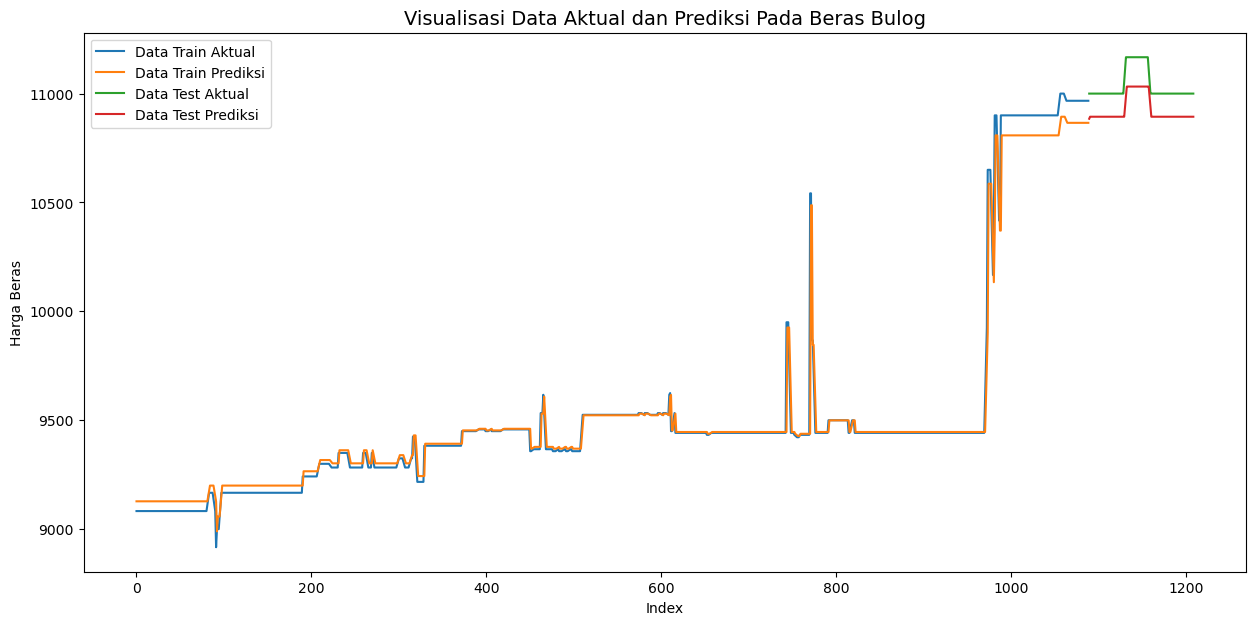

In [17]:
# denormalisasi  
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], 2))), axis=1))[:, 0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 2))), axis=1))[:, 0]
plot_predict_train = scaler.inverse_transform(np.concatenate((plot_predict_train, np.zeros((plot_predict_train.shape[0], 2))), axis=1))[:, 0]
plot_predict_test = scaler.inverse_transform(np.concatenate((plot_predict_test, np.zeros((plot_predict_test.shape[0], 2))), axis=1))[:, 0]

plt.figure(figsize=(15,7))
plt.plot(np.arange(len(Y_train)), Y_train, label='Data Train Aktual')
plt.plot(np.arange(len(Y_train)), plot_predict_train, label='Data Train Prediksi')
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Data Test Aktual')
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), plot_predict_test, label='Data Test Prediksi')
plt.title('Visualisasi Data Aktual dan Prediksi Pada Beras Bulog', fontsize=14)
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.legend()
plt.show()


In [18]:
# Menampilkan Data Test dan Prediksi dalam bentuk tabel
results = pd.DataFrame({
    'Data Test': Y_test,
    'Data Predict LSTM': plot_predict_test
})
print(results.head(10))
print(results.tail(10))

      Data Test  Data Predict LSTM
0  10999.999758       10884.431554
1  10999.999758       10893.755315
2  10999.999758       10893.755315
3  10999.999758       10893.755315
4  10999.999758       10893.755315
5  10999.999758       10893.755315
6  10999.999758       10893.755315
7  10999.999758       10893.755315
8  10999.999758       10893.755315
9  10999.999758       10893.755315
        Data Test  Data Predict LSTM
110  10999.999758       10893.755315
111  10999.999758       10893.755315
112  10999.999758       10893.755315
113  10999.999758       10893.755315
114  10999.999758       10893.755315
115  10999.999758       10893.755315
116  10999.999758       10893.755315
117  10999.999758       10893.755315
118  10999.999758       10893.755315
119  10999.999758       10893.755315


In [19]:
mape = mean_absolute_percentage_error(Y_test, plot_predict_test)
mape_percentage = round(mape * 100, 4)
print(f'Nilai MAPE = {mape_percentage}%')

Nilai MAPE = 1.0225%
